# Machine learning model training pipeline 

Modelling fraction of precipitation in different intensity bands. This notebook is designed to be run on SPICE.

## Set up

Firstly, we import relevant libraries

In [1]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf

In [3]:
import prd_pipeline

AzureML libraries not found, using local execution functions.


Set up MLops for experiment tracking 

In [4]:
import mlflow
mlflow.tensorflow.autolog()

In [5]:
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns


## Load and preprocess data

During data preparation, the fraction of precipitation in a set of intensity band has been calculated. The keys in this dictionary correspond to the bands central value, which has been used within the column names, while the list of two float values correspond to the lower and upper bounds of that band. This band information can also be found in the data prep config files.

In [6]:
bands = {
    '0.0':[0, 0.01],
    '0.25':[0.01, 0.5], 
    '2.5': [0.5, 4], 
    '7.0':[4, 10], 
    '10.0':[10,220]
}

In [7]:
intensity_band_template = '{source}_fraction_in_band_instant_{band_centre}'

We create a dictionary containing the column names for both model input features and target values. 

For profile features, features available in the prepared dataset are: 
- 'air_temperature'
- 'relative_humidity'
- 'wind_speed'
- 'wind_from_direction'
- 'cloud_volume_fraction'
- 'air_pressure'

For single level features, features available in the prepared dataset are:
- 'thickness_of_rainfall_amount'
- 'surface_altitude'
- 'air_pressure_at_sea_level'
- 'cloud_area_fraction'

In [8]:
target_parameter = [intensity_band_template.format(source='radar', band_centre=threshold) for threshold in bands.keys()]
nwp_comparison = [intensity_band_template.format(source='mogrepsg', band_centre=threshold) for threshold in bands.keys()]

profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction', 'cloud_volume_fraction'] #'air_pressure',
single_lvl_features = []#['surface_altitude']#'thickness_of_rainfall_amount', 'surface_altitude', 'air_pressure_at_sea_level', 'cloud_area_fraction'

In [9]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
    'nwp': nwp_comparison, 
    'metadata': ['time', 'realization', 'latitude', 'longitude']
} 

We load in most of the data, but reserve the first and last scenario in our dataset as unseen test scenarios.

In [10]:
dataset_dir = '/project/informatics_lab/precip_rediagnosis/train_202212'
dataset_dir = pathlib.Path(dataset_dir)

prd_path_list = [p1 for p1 in dataset_dir.rglob(f'{prd_pipeline.MERGED_PREFIX}*{prd_pipeline.CSV_FILE_SUFFIX}')]

In [11]:
merged_df = pd.concat([pd.read_csv(p1) for p1 in prd_path_list[1:-1]])

In [12]:
print(f'Filepaths for scenarios reserved for testing:\n {prd_path_list[0]} \n {prd_path_list[-1]}')

Filepaths for scenarios reserved for testing:
 /project/informatics_lab/precip_rediagnosis/train_202212/202002_storm_ciara/prd_merged_20200207T1800Z_20200210T1800Z.csv 
 /project/informatics_lab/precip_rediagnosis/train_202212/2022_storm_eunice_franklin/prd_merged_20220218T1200Z_20220221T1200Z.csv


Now that our data is loaded into a single pandas dataframe, we run preprocessing which split this into train and validate sets, as well as applying scaling to input features and reshaping verticle profile features to reintroduce height dimension.

In [14]:
test_fraction = 0.2
data_splits, data_dims_dict = prd_pipeline.preprocess_data(merged_df, feature_dict, test_fraction=test_fraction)

target has dims: 5
dropping datapoints where smallest bin radar_fraction_in_band_instant_0.0 = 1
getting profile columns
{'nprof_features': 5, 'nheights': 33, 'nsinglvl_features': 0, 'nbands': 5}


## Run experiment

Here we train and evaluate our model. All parameters and the output model will be logged through MLFlow.

First we check whether our MLFlow experiment already exists, if it does then we assign the experiment to a variable, if not we create an experiment.

In [15]:
exp_name='prd_fraction_models_mlflow'
try:
    exp1 = mlflow.create_experiment(exp_name)
except:
    exp1 = mlflow.get_experiment_by_name(exp_name)
exp1

<Experiment: artifact_location='file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns/4', experiment_id='4', lifecycle_stage='active', name='prd_fraction_models_mlflow', tags={}>

Create a dictionary containing our model hyperparameters

In [16]:
hyperparameter_dict = {
    'epochs': 10, 
    'learning_rate': 0.001, 
    'batch_size': 64,  
    'loss': tf.keras.losses.KLDivergence()
}

Now we create a model run within the MLFlow experiment from above, then run model training. In doing so all metrics and hyperparamters from model training will be tracked. We can also manually log parameters and metrics, such as model input features. 

In [17]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    mlflow.log_param('features', feature_dict['profile'] + feature_dict['single_level'])    
    model = prd_pipeline.build_model(**data_dims_dict)
    model.summary()
    model, history = prd_pipeline.train_model(model, data_splits, hyperparameter_dict, log_dir='./logs')

2022-12-19 09:25:52.787409: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 5)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 35, 5)       0           ['profile_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 33, 32)       480         ['zero_padding1d[0][0]']         
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 32)      0           ['conv1d[0][0]']                 
 D)                                                                                           

2022-12-19 09:33:22.262357: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/tmp/tmpe99bphwr/model/data/model/assets


Once model training is completed, we quickly plot comparisons of training and validation loss and accuracy curves, to check whether our model has started to converge and is therefore learning from our data. Similar plots are also available on MLFlow. 

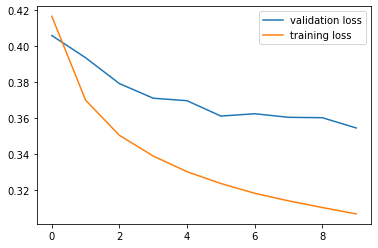

In [18]:
plt.plot(range(hyperparameter_dict['epochs']), history.history['val_loss'], label='validation loss')
plt.plot(range(hyperparameter_dict['epochs']), history.history['loss'], label='training loss')
plt.legend()
plt.show()

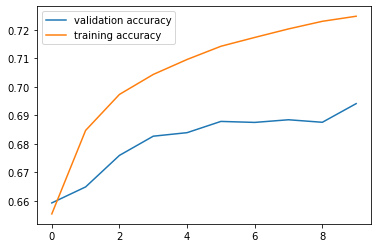

In [19]:
plt.plot(range(hyperparameter_dict['epochs']), history.history['val_accuracy'], label='validation accuracy')
plt.plot(range(hyperparameter_dict['epochs']), history.history['accuracy'], label='training accuracy')
plt.legend()
plt.show()

## Inference and model evaluation 

Now that a model has been trained, we can use the validation dataset to assess how this model is performing. We create predictions from our model using validation model inputs.

In [20]:
y_pred = model.predict(data_splits['X_val'])

We put our validation prediction into a pandas DataFrame to ease model assessment.

In [21]:
pred_column_names = [intensity_band_template.format(source='ml', band_centre=threshold) for threshold in bands.keys()]
y_pred_df = pd.DataFrame(y_pred, columns=pred_column_names)

evaluation_df = pd.concat([
    data_splits['meta_val'].reset_index(drop=True), 
    data_splits['nwp_val'].reset_index(drop=True), 
    data_splits['y_val'].reset_index(drop=True), 
    y_pred_df], axis=1)

We then use the Fractional Skill Score to assess model performance. This metrics requires us to transform the data to fraction exceeding thresholds, to do this take the cumulative sum of fractions in all bands with upper bound below or including the thresholds then subtraction from one.

In [22]:
source = ['radar', 'mogrepsg', 'ml']
for src in source:
    evaluation_df = prd_pipeline.calculate_p_exceedance(evaluation_df, src, bands, intensity_band_template)

Due to rounding error, some datapoints have very small negative probability of exceedance. In these cases we reassign negative values as zero. We then calculate the fractional skill score to compare both NWP probability and ML fraction prediction with radar. We can then compare how well machine learning and NWP perform for different precipitation thresholds.

For each upper bound in our set of precipiation intensity bands, we calculate the fractional skill score for exceeding that threshold. Firstly, we treat each ML prediction produced by each ensemble member as a deterministic forecast.

In [23]:
for threshold in bands.keys():
   
    ml_data = evaluation_df[f'ml_fraction_in_band_instant_{threshold}_exceedence']
    ml_data[ml_data<0]=0
    
    nwp_data = evaluation_df[f'mogrepsg_fraction_in_band_instant_{threshold}_exceedence']
    nwp_data[nwp_data<0]=0
    
    radar_data = evaluation_df[f'radar_fraction_in_band_instant_{threshold}_exceedence']
    radar_data[radar_data<0]=0
    
    print(f'ML FSS - P(precip>{bands[threshold][1]}mm): {prd_pipeline.fss(radar_data, ml_data):.4f}')
    print(f'NWP FSS - P(precip>{bands[threshold][1]}mm): {prd_pipeline.fss(radar_data, nwp_data):.4f}')

ML FSS - P(precip>0.01mm): 0.9184
NWP FSS - P(precip>0.01mm): 0.8310
ML FSS - P(precip>0.5mm): 0.8548
NWP FSS - P(precip>0.5mm): 0.7317
ML FSS - P(precip>4mm): 0.5292
NWP FSS - P(precip>4mm): 0.1631
ML FSS - P(precip>10mm): 0.3245
NWP FSS - P(precip>10mm): 0.0481
ML FSS - P(precip>220mm): 0.0000
NWP FSS - P(precip>220mm): 0.1737


We now take the average of the ML prediction made for each ensemble member at the same time and location, and calculate fractional skill score for these average values.

In [24]:
grouped = evaluation_df.groupby(['time', 'latitude', 'longitude']).agg('mean')
for threshold in bands.keys():

    ml_data = grouped[f'ml_fraction_in_band_instant_{threshold}_exceedence']
    ml_data[ml_data<0]=0
    
    nwp_data = grouped[f'mogrepsg_fraction_in_band_instant_{threshold}_exceedence']
    nwp_data[nwp_data<0]=0
    
    radar_data = grouped[f'radar_fraction_in_band_instant_{threshold}_exceedence']
    radar_data[radar_data<0]=0
    
    print(f'ML FSS - P(precip>{bands[threshold][1]}mm): {prd_pipeline.fss(radar_data, ml_data):.4f}')
    print(f'NWP FSS - P(precip>{bands[threshold][1]}mm): {prd_pipeline.fss(radar_data, nwp_data):.4f}')

ML FSS - P(precip>0.01mm): 0.9302
NWP FSS - P(precip>0.01mm): 0.8310
ML FSS - P(precip>0.5mm): 0.8780
NWP FSS - P(precip>0.5mm): 0.7316
ML FSS - P(precip>4mm): 0.5627
NWP FSS - P(precip>4mm): 0.1631
ML FSS - P(precip>10mm): 0.3475
NWP FSS - P(precip>10mm): 0.0481
ML FSS - P(precip>220mm): 0.0000
NWP FSS - P(precip>220mm): 0.1737
